In [45]:
import json
import glob
import os

In [55]:
list_data = glob.glob("/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/*")
list_data

['/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0825_1925_llava...mstar_llava_model_args_ea2307',
 '/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0825_1940_llava...mstar_llava_model_args_3775f6',
 '/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0825_1838_llava...mstar_llava_model_args_579495',
 '/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0825_2229_llava...mstar_llava_model_args_5a42c1',
 '/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0903_1840_llava...mstar_llava_model_args_c753cd',
 '/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0825_2149_llava...mstar_llava_model_args_5a42c1',
 '/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36/analysts/diversity/0825_2150_llava...mstar_llava_model

In [56]:
diver_logs_overall = {}

for root in list_data:
    files = glob.glob(f"{root}/*.json")
    moe_method = None
    
    for data in files:
        name_dataset = os.path.basename(data).split(".")[0]
        if "results" in name_dataset:
            with open(data, "r") as f:
                result = json.load(f)
            moe_method = result['model_configs']['model_args'].split(",")[0].split("/")[-1]
            diver_logs_overall[moe_method] = {}
                
    for data in files:
        name_dataset = os.path.basename(data).split(".")[0]
        if "results" in name_dataset:
            
            continue
        
        with open(data, "r") as f:
            data_sig = json.load(f)
        diver_logs = {}
        for sample in data_sig["logs"]:
            for id_layer, value in sample['logs_metrics_vision'][0][0].items():
                if isinstance(value, float) == True: 
                    # print(value)
                    continue
                # print(value)
                # print(id_layer)
                if id_layer not in diver_logs:
                    diver_logs[id_layer] = 0
                diver_logs[id_layer] += value['diver_loss']
            for id_layer in diver_logs.keys():
                diver_logs[id_layer] /= len(sample)

        diver_logs_overall[moe_method][name_dataset] = diver_logs

In [57]:
diver_logs_overall.keys()

dict_keys(['Full_xmoe', 'Full_smoe', 'Full_smoe_sigmoidgating', 'Full_smoe_plus_plus', 'Full_smoe_tcmoe', 'Full_smoe_sharev3', 'Full_smoe_share'])

In [ ]:

label2id_stage = {
    'Full_smoe': 0,
    'Full_xmoe': 1,
    'Full_smoe_sigmoidgating': 2,
    'Full_smoe_share': 3,
    'Full_smoe_sharev3': 4,
    'Full_smoe_tcmoe': 5,
    'Full_smoe_plus_plus': 6
}

moe2name = {
    'Full_smoe': "SMoE",
    'Full_xmoe': "XMoE",
    'Full_smoe_sigmoidgating': r"$\sigma$-MoE",
    'Full_smoe_share': "SharedE-V2",
    'Full_smoe_sharev3': "SharedE-V3",
    'Full_smoe_tcmoe': "TC-MoE",
    'Full_smoe_plus_plus': "MoE++"
}

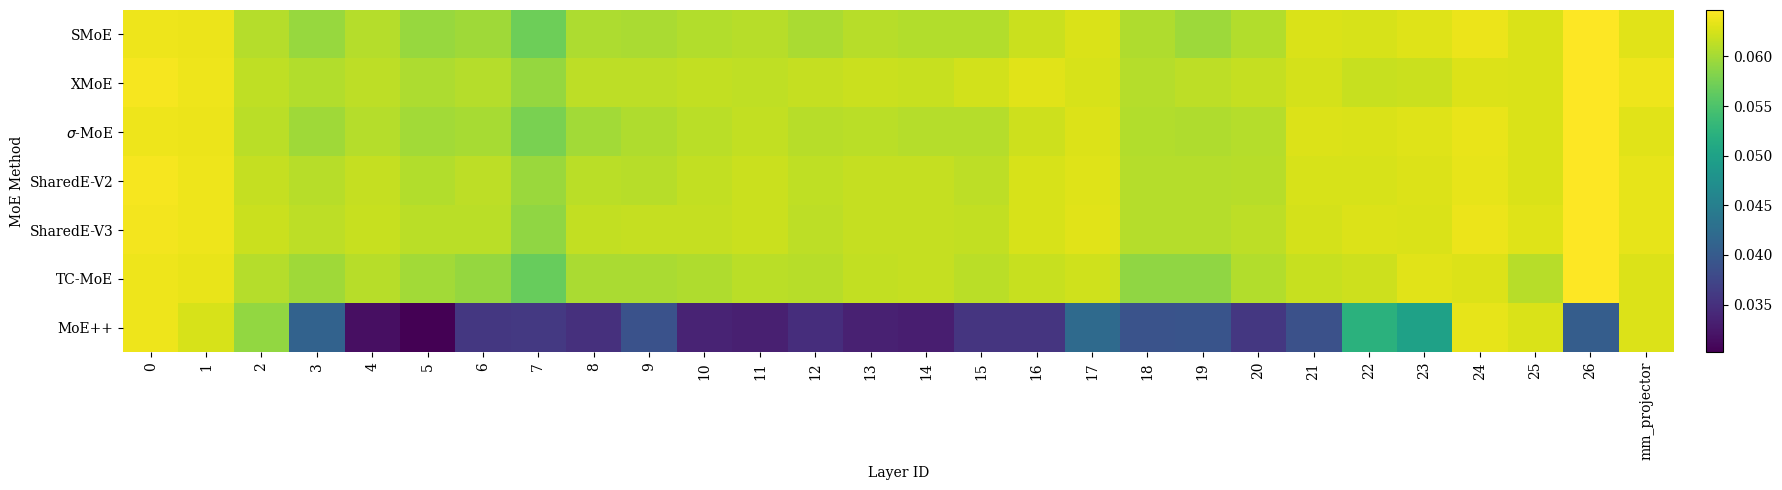

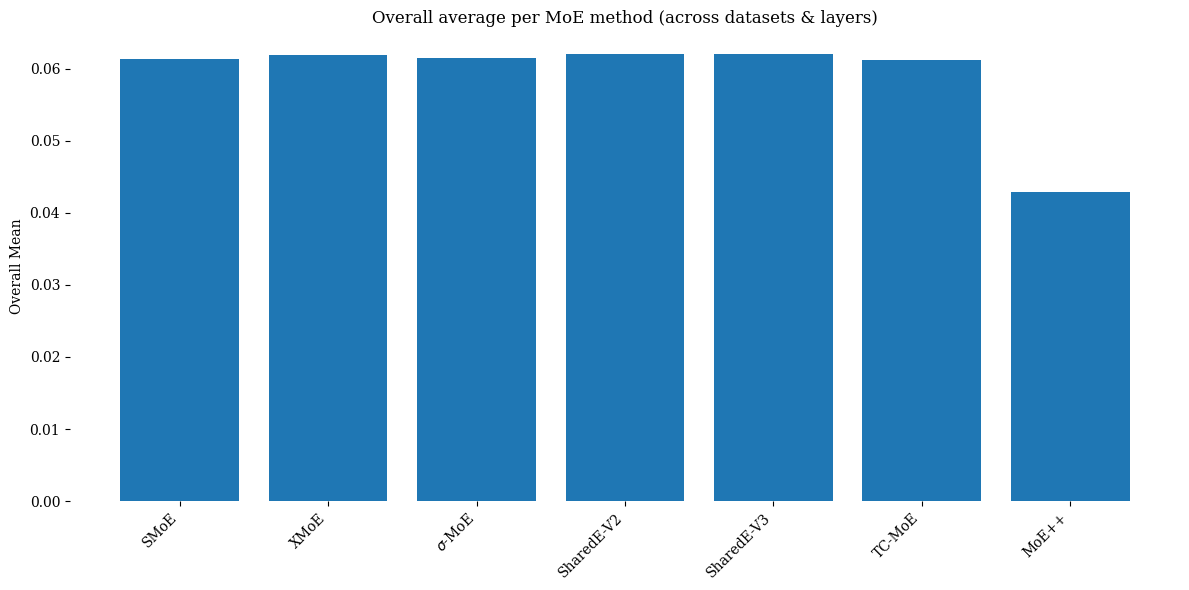

In [66]:
# Parse the provided Python-dict-like string, compute summaries, and plot 2 figures
import ast
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
plt.rcParams['font.family'] = 'DejaVu Serif'
fontsize = 19
data = diver_logs_overall

label2id_stage = {
    'Full_smoe': 0,
    'Full_xmoe': 1,
    'Full_smoe_sigmoidgating': 2,
    'Full_smoe_share': 3,
    'Full_smoe_sharev3': 4,
    'Full_smoe_tcmoe': 5,
    'Full_smoe_plus_plus': 6
}

moe2name = {
    'Full_smoe': "SMoE",
    'Full_xmoe': "XMoE",
    'Full_smoe_sigmoidgating': r"$\sigma$-MoE",
    'Full_smoe_share': "SharedE-V2",
    'Full_smoe_sharev3': "SharedE-V3",
    'Full_smoe_tcmoe': "TC-MoE",
    'Full_smoe_plus_plus': "MoE++"
}

# Collect layer ids (string keys "0".."26" plus "mm_projector"), sorted with mm_projector last
def sorted_layer_keys(sample_dataset_dict):
    numeric = sorted([k for k in sample_dataset_dict.keys() if k != "mm_projector"], key=lambda x: int(x))
    if "mm_projector" in sample_dataset_dict:
        numeric.append("mm_projector")
    return numeric

# Use any dataset from any method to derive the layer list
any_method = next(iter(data.values()))
any_dataset = next(iter(any_method.values()))
layers = sorted_layer_keys(any_dataset)

# Methods sorted by label2id_stage
methods = sorted(data.keys(), key=lambda m: label2id_stage.get(m, 999))
method_labels = [moe2name.get(m, m) for m in methods]

# Compute layer-wise averages per method across datasets
method_layer_avg = {}
for method, datasets in data.items():
    layer_vals = {layer: [] for layer in layers}
    for ds_name, ds_vals in datasets.items():
        for layer in layers:
            v = ds_vals.get(layer, np.nan)
            layer_vals[layer].append(v)
    method_layer_avg[method] = {layer: float(np.nanmean(layer_vals[layer])) for layer in layers}

# Build matrix for heatmap
heatmap_matrix = np.array([[method_layer_avg[m][l] for l in layers] for m in methods])

# ========== Figure 1 ==========
fig1, ax1 = plt.subplots(figsize=(18, 5))
im = ax1.imshow(heatmap_matrix, aspect='auto', interpolation='nearest')
ax1.set_xticks(np.arange(len(layers)), labels=layers, rotation=90)
ax1.set_yticks(np.arange(len(methods)), labels=method_labels)
ax1.set_xlabel("Layer ID")
ax1.set_ylabel("MoE Method")

# Remove border spines
for spine in ax1.spines.values():
    spine.set_visible(False)

cbar = plt.colorbar(im, fraction=0.025, pad=0.02, ax=ax1)
fig1.tight_layout()

fig1_path_png = Path("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/figures/diversity_layer_heatmap.png")
fig1_path_pdf = Path("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/figures/diversity_layer_heatmap.pdf")
fig1.savefig(fig1_path_png, dpi=300)
fig1.savefig(fig1_path_pdf)
plt.show()

# ========== Figure 2 ==========
method_global_avg = {m: float(np.mean(list(layers_dict.values())))
                     for m, layers_dict in method_layer_avg.items()}

fig2, ax2 = plt.subplots(figsize=(12, 6))
x = np.arange(len(methods))
vals = [method_global_avg[m] for m in methods]
ax2.bar(x, vals)
ax2.set_xticks(x, method_labels, rotation=45, ha='right')
ax2.set_ylabel("Overall Mean")
ax2.set_title("Overall average per MoE method (across datasets & layers)")

# Remove border spines
for spine in ax2.spines.values():
    spine.set_visible(False)

fig2.tight_layout()

fig2_path_png = Path("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/figures/diversity_method_overall_bar.png")
fig2_path_pdf = Path("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/figures/diversity_method_overall_bar.pdf")
fig2.savefig(fig2_path_png, dpi=300)
fig2.savefig(fig2_path_pdf)
plt.show()


In [61]:
methods

['Full_xmoe',
 'Full_smoe',
 'Full_smoe_sigmoidgating',
 'Full_smoe_plus_plus',
 'Full_smoe_tcmoe',
 'Full_smoe_sharev3',
 'Full_smoe_share']